# Numerical Propagation Example

This is an example of how to perform a numerical propagation in Orekit.

In [1]:
%matplotlib inline

Set up the orekit environment and start the Java VM

In [2]:
import orekit
vm = orekit.initVM()
# Now we have populated the namespace with the orekit classes

In [3]:
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

In [4]:
from java.util import Arrays
from orekit import JArray_double

In [5]:
from org.orekit.bodies import  OneAxisEllipsoid
from org.orekit.frames import  FramesFactory
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.orbits import KeplerianOrbit
from org.orekit.utils import Constants
from org.orekit.propagation.analytical import EcksteinHechlerPropagator
from org.orekit.propagation.analytical.tle import TLEPropagator
from org.orekit.propagation.conversion import FiniteDifferencePropagatorConverter
from org.orekit.propagation.conversion import TLEPropagatorBuilder
from datetime import datetime
from org.orekit.propagation import SpacecraftState
from org.orekit.orbits import OrbitType, PositionAngle
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.utils import IERSConventions

In [6]:
import matplotlib.dates as mdates
from math import radians
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Some Constants
ae = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
mu = Constants.WGS84_EARTH_MU
utc = TimeScalesFactory.getUTC()

### Initial osculating orbit

In [8]:
ra = 814 * 1000         # km Apogee
rp = 786 * 1000         # km Perigee
i = radians(98.55)      # inclination
omega = radians(90.0)   # perigee argument
raan = radians(5.1917)  # right ascension of ascending node
lv = radians(0.0567634)    # True anomaly
epochDate = AbsoluteDate(2012, 1, 26, 16, 0, 00.000, utc)

a = (rp + ra + 2 * ae) / 2.0    # semi major axis in km
e = 1.0 - (rp + ae) / a

#Inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

#Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, epochDate, mu)
satellite_mass = 100.0 # kg
initialState = SpacecraftState(initialOrbit, satellite_mass) 

### Set up numerical propagator

The numerical propagation is based on an integrator with variable step size. These are specified, as other time units in Orekit, in seconds.

In [9]:
minStep = 0.001;
maxstep = 1000.0;
initStep = 60.0

The spatial tolerance can be specified (meters)

In [10]:
positionTolerance = 1.0 
orbitType = OrbitType.CARTESIAN
tol = NumericalPropagator.tolerances(positionTolerance, initialOrbit, orbitType)

The actual integrator, in this case DormandPrince853, is part of the Hipparchos library. Note that the tolerances needs casting in Python to an array of doubles (floats).

In [11]:
integrator = DormandPrince853Integrator(minStep, maxstep, 
    JArray_double.cast_(tol[0]),  # Double array of doubles needs to be casted in Python
    JArray_double.cast_(tol[1]))
integrator.setInitialStepSize(initStep)

In [12]:
propagator_num = NumericalPropagator(integrator)
propagator_num.setOrbitType(orbitType)
propagator_num.setInitialState(initialState)

For the propagator to make sense it needs some forces acting on the satellite. Here we are adding a gravity field model.

For a more detailed propagation, other force models can be added.

In [13]:
itrf    = FramesFactory.getITRF(IERSConventions.IERS_2010, True) # International Terrestrial Reference Frame, earth fixed
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                         Constants.WGS84_EARTH_FLATTENING,
                         itrf)
gravityProvider = GravityFieldFactory.getNormalizedProvider(8, 8)
propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(earth.getBodyFrame(), gravityProvider))

### Propagate orbit numerically

In [14]:
## Create time vector
startDate = AbsoluteDate(2012, 1, 26, 11, 0, 00.000, utc)

#Overall duration in seconds for extrapolation
duration = 86400 * 3 
step_time = 60 * 3

# Time array in orekit AbsoluteDate format
t = [startDate.shiftedBy(float(dt)) \
        for dt in np.arange(0, duration, step_time)]

state = [propagator_num.propagate(tt) for tt in t]
pos = [propagator_num.propagate(tt).getPVCoordinates().getPosition() for tt in t]

In [15]:
print(pos[0:9])

[<Vector3D: {-1,485,060.2307462483; -1,172,149.8693822566; 6,910,872.881824422}>, <Vector3D: {-2,761,405.239388942; -1,221,665.2753032285; 6,499,798.932423361}>, <Vector3D: {-3,941,543.3605203643; -1,228,619.3347693253; 5,861,696.564684098}>, <Vector3D: {-4,984,385.936838593; -1,192,776.0424061927; 5,018,888.543765761}>, <Vector3D: {-5,853,669.825255838; -1,115,398.1555035466; 4,000,866.777300194}>, <Vector3D: {-6,519,250.743920913; -999,204.5664276541; 2,843,253.828051501}>, <Vector3D: {-6,958,182.346440771; -848,272.567885797; 1,586,529.4319431493}>, <Vector3D: {-7,155,526.953570646; -667,888.426544926; 274,568.035712446}>, <Vector3D: {-7,104,859.033952237; -464,353.5041740214; -1,046,949.3852071227}>]


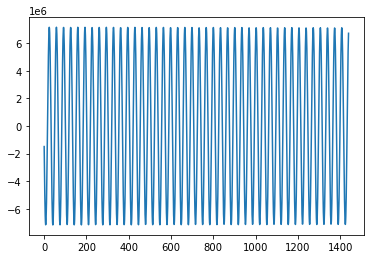

In [16]:
plt.plot([n.x for n in pos])